In [1]:
import os
import sys
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np

In [2]:
src_path = os.path.abspath('src')
sys.path.append(src_path)

In [3]:
POINTS_PARAMETER = 8192
POINTS_PARAMETER_HAT = 1024

In [4]:
from compute_distances import bhattacharyya_distance, jensen_shannon_divergence, \
    hellinger_distance, wasserstein_distance_O2
    
from helpers import get_point_cloud_from_off   

In [8]:
airplane, airplane_pcd = get_point_cloud_from_off('data/ModelNet40/airplane/test/airplane_0628.off', num_points=POINTS_PARAMETER)
airplane_hat, airplane_hat_pcd = get_point_cloud_from_off('data/ModelNet40/airplane/test/airplane_0628.off', num_points=POINTS_PARAMETER_HAT)
plant, plant_pcd = get_point_cloud_from_off('data/ModelNet40/plant/test/plant_0251.off', num_points=POINTS_PARAMETER)
lamp, lamp_pcd = get_point_cloud_from_off('data/ModelNet40/lamp/test/lamp_0132.off', num_points=POINTS_PARAMETER)

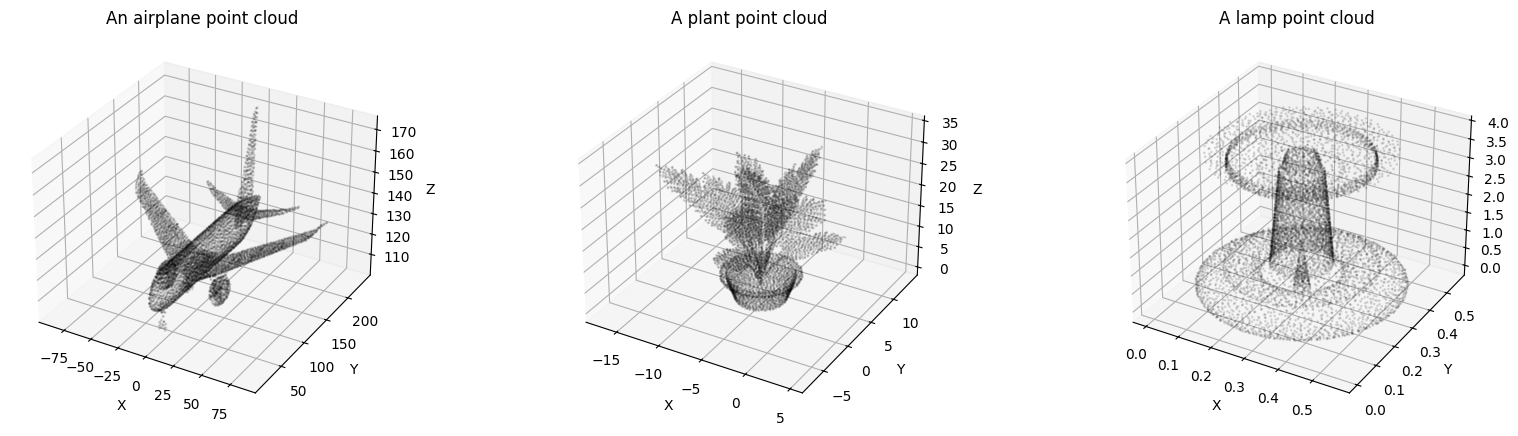

In [9]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(airplane[:, 0], airplane[:, 1], airplane[:, 2], s=1, c='black', alpha=0.1)
#ax.scatter(airplane_hat[:, 0], airplane_hat[:, 1], airplane_hat[:, 2], s=1, c='lime', alpha=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('An airplane point cloud')
ax = fig.add_subplot(132, projection='3d')
ax.scatter(plant[:, 0], plant[:, 1], plant[:, 2], s=1, c='black', alpha=0.1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('A plant point cloud');
ax = fig.add_subplot(133, projection='3d')
ax.scatter(lamp[:, 0], lamp[:, 1], lamp[:, 2], s=1, c='black', alpha=0.1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('A lamp point cloud');

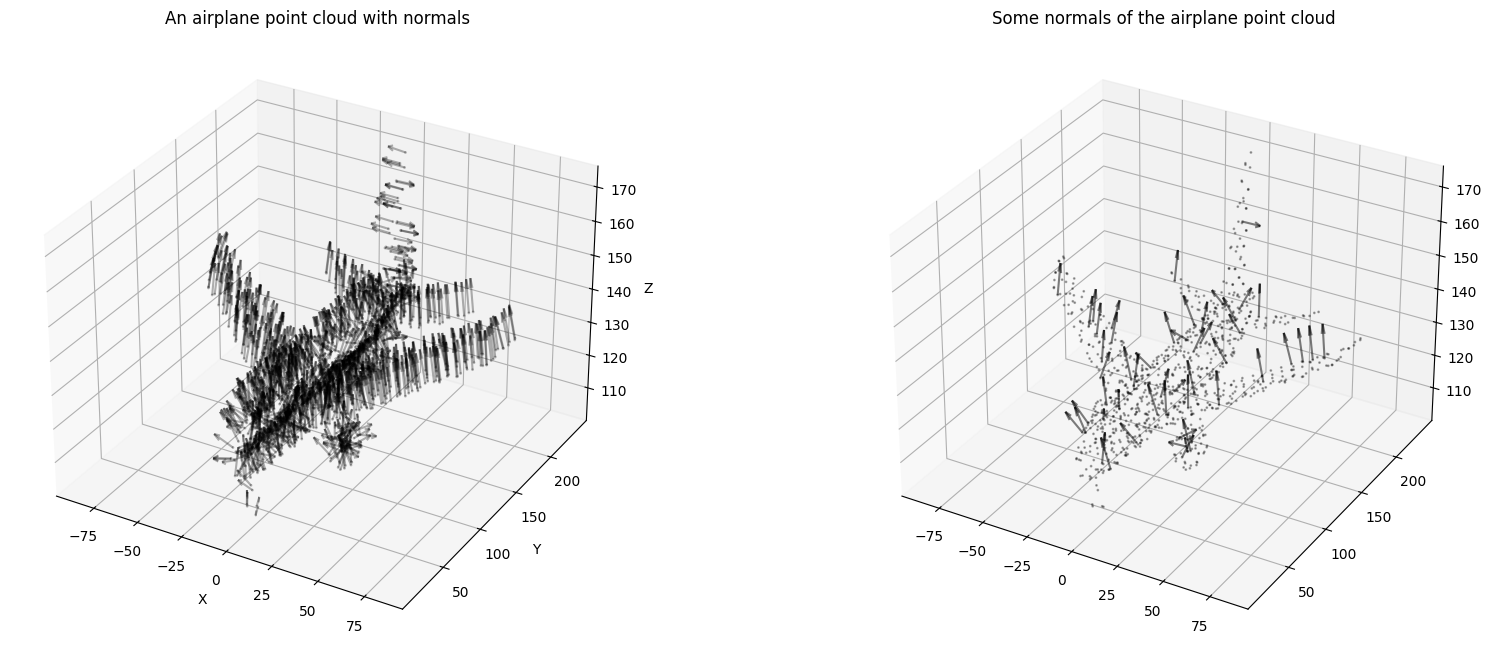

In [56]:
airplane_hat_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=10, max_nn=30))
airplane_hat_pcd.normalize_normals()
airplane_normals = np.asarray(airplane_hat_pcd.normals)

points = airplane_hat
normals = airplane_normals
num_points_to_plot = int(points.shape[0] * 0.05)
random_indices = np.random.choice(points.shape[0], num_points_to_plot, replace=False)

points_plot = points[random_indices, :]
normals_plot = normals[random_indices, :]

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(airplane_hat[:, 0], airplane_hat[:, 1], airplane_hat[:, 2], s=1, c='gray', alpha=0.5)
scale_factor = 10
ax.quiver(airplane_hat[:, 0], airplane_hat[:, 1], airplane_hat[:, 2], 
              airplane_normals[:, 0] * scale_factor, airplane_normals[:, 1] * scale_factor, airplane_normals[:, 2] * scale_factor,
              color='black', length=1, normalize=False, label='Normals', alpha=0.3)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('An airplane point cloud with normals');

ax = fig.add_subplot(122, projection='3d')

ax.scatter(airplane_hat[:, 0], airplane_hat[:, 1], airplane_hat[:, 2], s=1, c='black', alpha=0.3)
#ax.scatter(points_plot[:, 0], points_plot[:, 1], points_plot[:, 2], s=1, c='blue', alpha=1)

scale_factor = 10 
ax.quiver(points_plot[:, 0], points_plot[:, 1], points_plot[:, 2], 
          normals_plot[:, 0] * scale_factor, normals_plot[:, 1] * scale_factor, normals_plot[:, 2] * scale_factor,
          color='black', length=1, normalize=False, label='Normales', alpha=0.5)

ax.set_title('Some normals of the airplane point cloud');

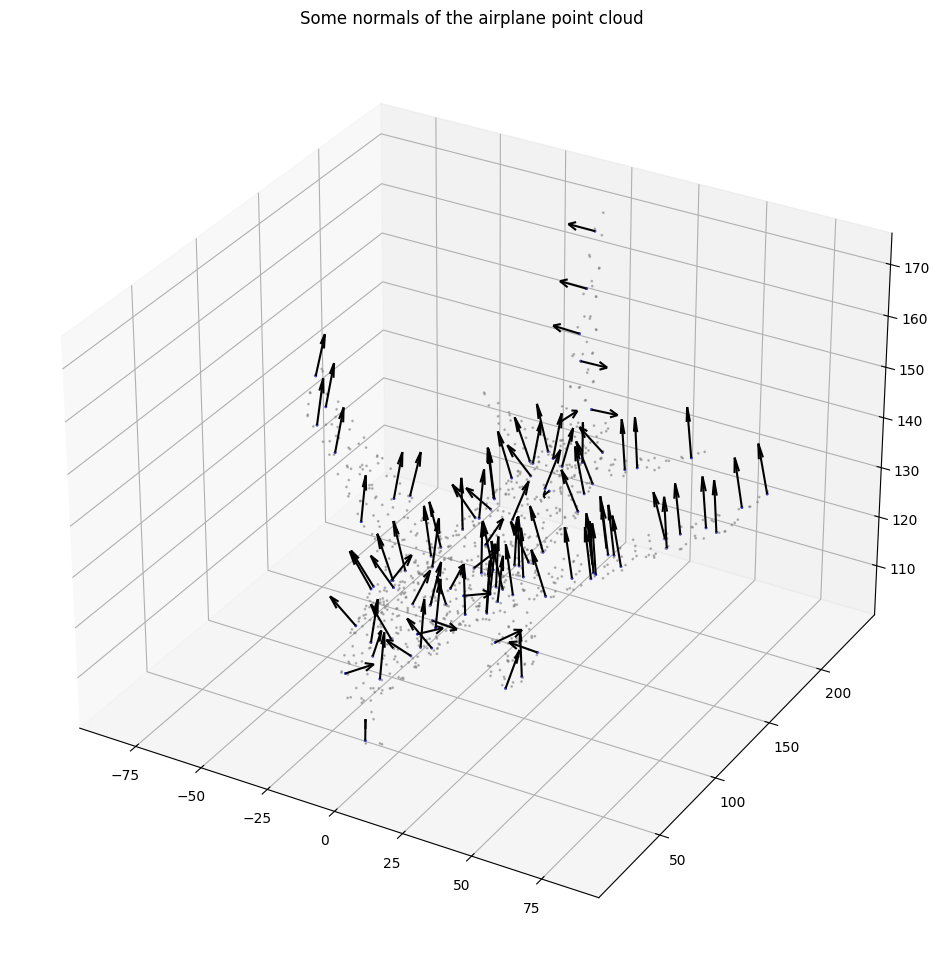

In [50]:
points = airplane_hat
normals = airplane_normals
num_points_to_plot = int(points.shape[0] * 0.1)
random_indices = np.random.choice(points.shape[0], num_points_to_plot, replace=False)

points_plot = points[random_indices, :]
normals_plot = normals[random_indices, :]

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(airplane_hat[:, 0], airplane_hat[:, 1], airplane_hat[:, 2], s=1, c='gray', alpha=0.5)
ax.scatter(points_plot[:, 0], points_plot[:, 1], points_plot[:, 2], s=1, c='blue', alpha=1)

scale_factor = 10 
ax.quiver(points_plot[:, 0], points_plot[:, 1], points_plot[:, 2], 
          normals_plot[:, 0] * scale_factor, normals_plot[:, 1] * scale_factor, normals_plot[:, 2] * scale_factor,
          color='black', length=1, normalize=False, label='Normales')

ax.set_title('Some normals of the airplane point cloud')
plt.show()